In [1]:
from siepic import all as pdk
from ipkiss3 import all as i3
from ipkiss3 import constants
from ipkiss.process.layer_map import GenericGdsiiPPLayerOutputMap
from pteam_library_siepic.all import UnitCellRectangular, UniformWBG
from pteam_library_siepic.components.grating_unit_cell.fitting import create_uc_model_data
from wbg_cell import WBGCircuit
from wbg_cell_calib import WBGCircuit_calib

from datetime import datetime
from scipy.io import savemat, loadmat
import matplotlib.gridspec as gridspec
import numpy as np
import pylab as plt
import pickle


In [2]:
# We make a copy of the layer dictionary to freely modify it
pplayer_map = dict(i3.TECH.GDSII.LAYERTABLE)
# Write the content to be written on WG_P6NM on Silicon layer directly
pplayer_map[i3.TECH.PROCESS.WG_P6NM, i3.TECH.PURPOSE.DRAWING] = pplayer_map[i3.TECH.PROCESS.WG, i3.TECH.PURPOSE.DRAWING]
output_layer_map = GenericGdsiiPPLayerOutputMap(pplayer_map=pplayer_map)

In [3]:
x0 = 40.0
y0 = 15.0
spacing_x = 80.0

insts = dict()
specs = []

In [4]:
# Create the floor plan for EdX design area
floorplan = pdk.FloorPlan(name="FLOORPLAN", size=(605.0, 410.0))

# Add the floor plan to the instances dict and place it at (0.0, 0.0)
insts["floorplan"] = floorplan
specs.append(i3.Place("floorplan", (0.0, 0.0)))
# Initialize the text label dictionary
text_label_dict = {}  # Text labels dictionary for automated measurement labels
circuit_cell_names = []  # Constituent circuit cell names list

In [5]:
########################################################################################################################
# Set up the unit cell, WBG and then the full circuit.
########################################################################################################################

width = 0.51
deltawidth = 0.099
dc = 0.2
lambdab = 0.335

# Third parameter variation
uc3 = UnitCellRectangular(
    width=width,
    deltawidth=deltawidth,
    length1=(1 - dc) * lambdab,
    length2=dc * lambdab,
)

wbg3 = UniformWBG(uc=uc3, n_uc=300)
wbg_circuit_name3 = "WBGs3"
wbg_circuit3 = WBGCircuit(wbg=wbg3, name=wbg_circuit_name3)
# Add the circuit
insts[wbg_circuit_name3] = wbg_circuit3
specs.append(i3.Place(wbg_circuit_name3, (x0, y0)))
# Put the measurement label
meas_label = f"{wbg_circuit3.measurement_label_pretext}{wbg_circuit_name3}"
meas_label_coord = wbg_circuit3.measurement_label_position + (x0, y0)
text_label_dict[wbg_circuit_name3] = [meas_label, meas_label_coord]
circuit_cell_names.append(wbg_circuit_name3)


In [6]:
# Give space between adjacent circuits
x0 += 290

In [7]:
# The calibration circuit
wbg_circuit_calib_name = "WBGsC"
wbg_circuit_calib = WBGCircuit_calib(name=wbg_circuit_calib_name)
# Add the circuit
insts[wbg_circuit_calib_name] = wbg_circuit_calib
specs.append(i3.Place(wbg_circuit_calib_name, (x0, y0)))
# Put the measurement label
meas_label = f"{wbg_circuit_calib.measurement_label_pretext}{wbg_circuit_calib_name}"
meas_label_coord = wbg_circuit_calib.measurement_label_position + (x0, y0)
text_label_dict[wbg_circuit_calib_name] = [meas_label, meas_label_coord]
circuit_cell_names.append(wbg_circuit_calib_name)

In [8]:
# Create models for different unit cells if necessary
create_uc_model_data(uc_pcell=uc3)  # This is the default cell

Calculate the performance of the unit cell for different wavelengths and temperatures for TE polarisation.
Calculate the performance of the unit cell for different wavelengths and temperatures for TM polarisation.
Retrieving the fitting coefficients.
Saving the fitting coefficients to a text file.


In [9]:
# Create the final design with i3.Circuit
top_cell2 = i3.Circuit(
    name=f"EBeam_OngunArisev_D_{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}",
    insts=insts,
    specs=specs,
)


In [10]:
# Bigger visualization
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100


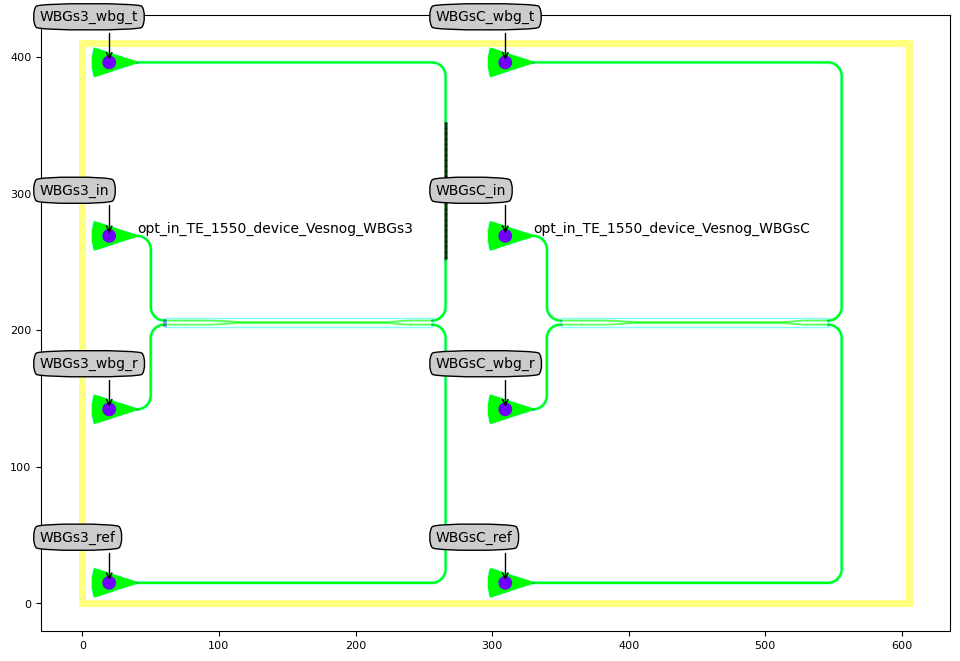

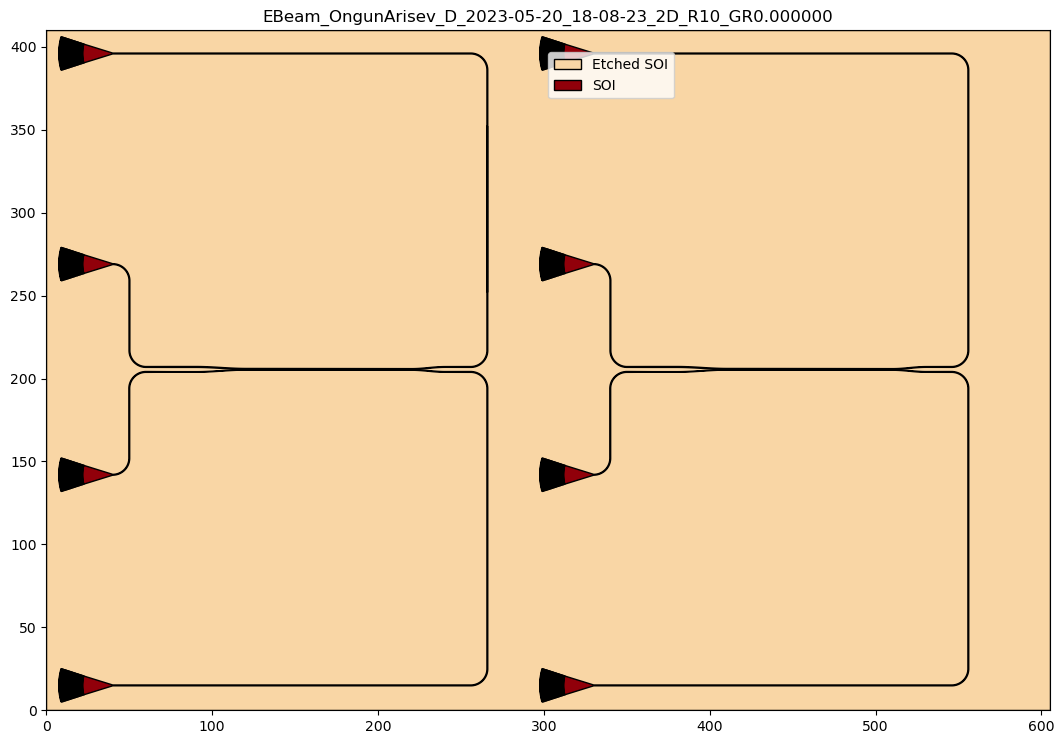

C:\Users\ongun\PycharmProjects\ipkiss_training\EBeam_Vesnog_D.gds

In [11]:
# Any number of layout primitives can be added here
text_elems2 = []
# For the GDS text elements for automated measurement
for cell in circuit_cell_names:
    text_label = text_label_dict[cell][0]
    text_label_coord = text_label_dict[cell][1]
    text_elems2 += i3.Label(layer=i3.TECH.PPLAYER.TEXT, text=text_label,
                          coordinate=text_label_coord,
                          alignment=(constants.TEXT.ALIGN.LEFT, constants.TEXT.ALIGN.BOTTOM), height=2)

# Layout
filename = "EBeam_Vesnog_D.gds"
cell_lv = top_cell2.Layout()
cell_lv.append(text_elems2)
cell_lv.visualize(annotate=True)
cell_lv.visualize_2d()
cell_lv.write_gdsii(filename, layer_map=output_layer_map)

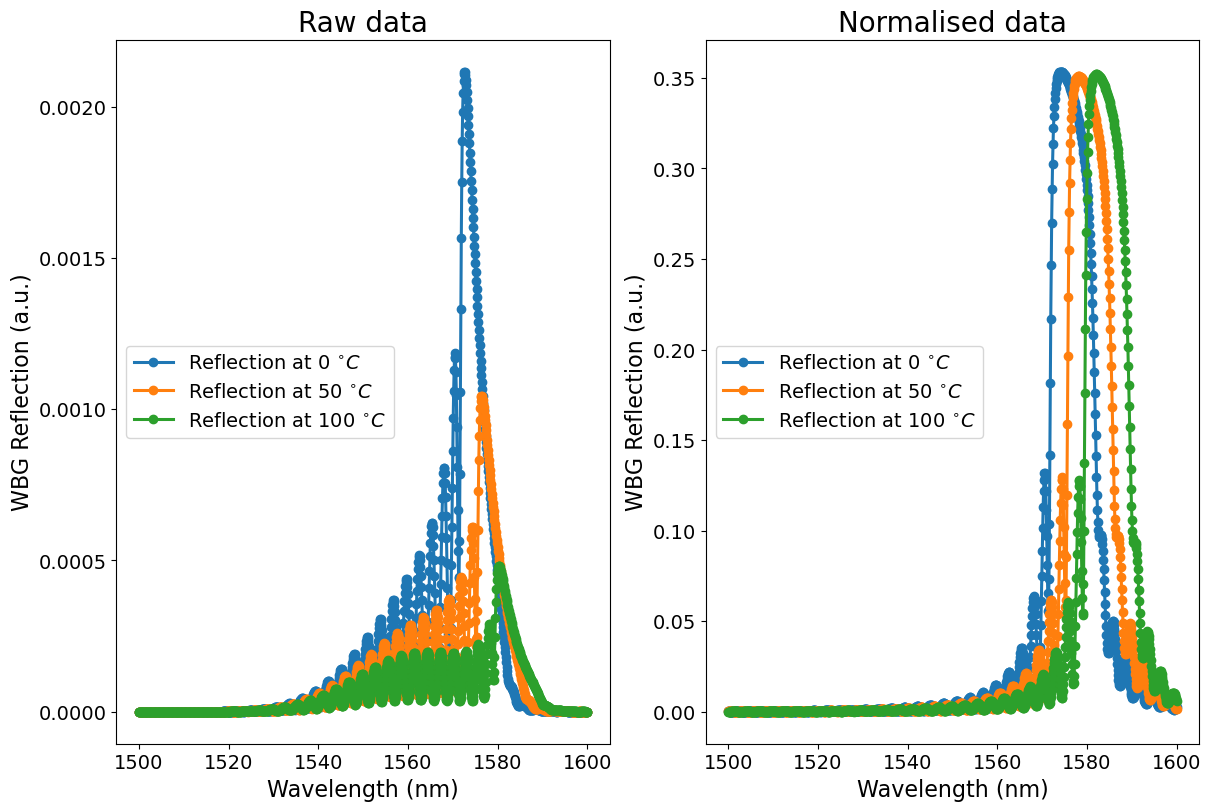

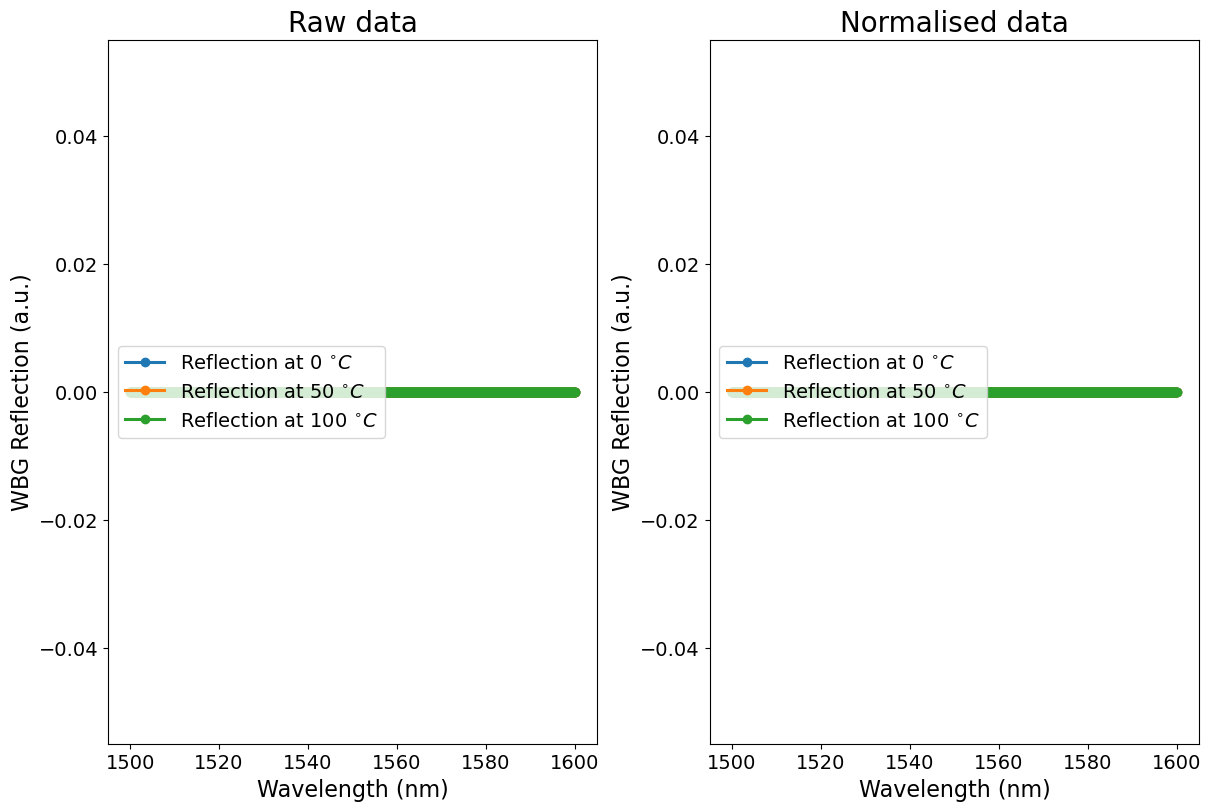

Done


In [12]:
########################################################################################################################
# Simulate the circuits
########################################################################################################################

for wbg in [wbg3, wbg_circuit_calib]:

    temperatures = np.linspace(273, 373, 3)
    wavelengths = np.arange(1.50, 1.60, 0.0001)

    fig = plt.figure(constrained_layout=True)
    gs = gridspec.GridSpec(1, 2, figure=fig)
    axes_sparam = [fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[0, 1])]

    axes_sparam[0].set_xlabel(r"Wavelength (nm)", fontsize=16)
    axes_sparam[0].set_ylabel("WBG Reflection (a.u.)", fontsize=16)
    axes_sparam[0].set_title("Raw data", fontsize=20)

    axes_sparam[1].set_xlabel(r"Wavelength (nm)", fontsize=16)
    axes_sparam[1].set_ylabel("WBG Reflection (a.u.)", fontsize=16)
    axes_sparam[1].set_title("Normalised data", fontsize=20)

    for temperature in temperatures:
        if isinstance(wbg, UniformWBG):
            wbg.CircuitModel(temperature=temperature)
            full_circuit = WBGCircuit(wbg=wbg)
        else:
            full_circuit = wbg

        full_circuit_cm = full_circuit.CircuitModel()
        full_circuit_Smatrix = full_circuit_cm.get_smatrix(wavelengths=wavelengths)
        reflection = i3.signal_power(full_circuit_Smatrix["in:0", "wbg_r:0"])
        transmission_ref = i3.signal_power(full_circuit_Smatrix["in:0", "ref:0"])

        axes_sparam[0].plot(
            wavelengths * 1000,
            reflection,
            "o-",
            linewidth=2.2,
            label=r"Reflection at " + str(int(temperature - 273)) + r" $^{\circ}C$",
        )
        axes_sparam[1].plot(
            wavelengths * 1000,
            reflection / transmission_ref,
            "o-",
            linewidth=2.2,
            label=r"Reflection at " + str(int(temperature - 273)) + r" $^{\circ}C$",
        )

    axes_sparam[0].legend(fontsize=14, loc=6)
    axes_sparam[1].legend(fontsize=14, loc=6)
    axes_sparam[0].tick_params(which="both", labelsize=14)
    axes_sparam[1].tick_params(which="both", labelsize=14)
    m_dict = {"wavelength": wavelengths, "reflection": reflection,
              "transmission_ref": transmission_ref, "full_circuit_Smatrix": full_circuit_Smatrix}
    if isinstance(wbg, UniformWBG):
        savemat(f'./data/wbg_w_{wbg.uc.width}_dw_{wbg.uc.deltawidth}_l1_{wbg.uc.length1}_l2_{wbg.uc.length2}.mat', m_dict)
        with open(f'./data/wbg_w_{wbg.uc.width}_dw_{wbg.uc.deltawidth}_l1_{wbg.uc.length1}_l2_{wbg.uc.length2}.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
            pickle.dump([wavelengths, reflection, transmission_ref, full_circuit_Smatrix], f)
            # pickle.load(open('./data/wbg_w_0.5_dw_0.089_l1_0.26_l2_0.065.pkl', 'rb'))  # Example command to read
    else:
        savemat(f'./data/wbg_calibration.mat', m_dict)
        with open(f'./data/wbg_calibration.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
            pickle.dump([wavelengths, reflection, transmission_ref, full_circuit_Smatrix], f)
plt.show()

print("Done")
